# Basic seafloor detection with echopype

>
>
> ⚠️ **Disclaimer**: This notebook uses features that are not yet available in the latest official `echopype` release.
>
> To run this notebook, you must clone `echopype` and install it in editable mode:
>
> ```bash
> git clone https://github.com/OSOceanAcoustics/echopype.git
> cd echopype
> pip install -e ".[dev]"
> ```
>
>


This notebook demonstrates how to:
- Load and preprocess echosounder data with `echopype`
- Detect the seafloor using a basic thresholding method via `detect_seafloor`
- Export and visualise the bottom line with `echoregions`
- Apply the seafloor mask to the Sv data using `apply_mask`
- Compute and visualise MVBS (mean volume backscattering strength) from masked data






First, we load the acoustic data.

In [1]:
import echopype as ep

raw_path = "s3://noaa-wcsd-pds/data/raw/Bell_M._Shimada/SH2306/EK80/Hake-D20230811-T165727.raw"
ed = ep.open_raw(
    raw_path,
    sonar_model="EK80",
    storage_options={"anon": True},  # open bucket, otherwise need credential
)

In [2]:
type(ed)

echopype.echodata.echodata.EchoData

We compute Sv and add transducer depth.

In [3]:
# Use the correct waveform_mode and encode_mode combination
ds_Sv = ep.calibrate.compute_Sv(ed, waveform_mode="CW", encode_mode="power")

# depth_offset=9.8 because transducer was on a lowered centerboard at 9.8 m deep
ds_Sv = ep.consolidate.add_depth(ds_Sv, ed, depth_offset=9.8)

We print the channel names.

In [4]:
channel_names = ds_Sv['channel'].values
channel_names

array(['WBT 400140-15 ES120-7C_ES', 'WBT 400141-15 ES18_ES',
       'WBT 400142-15 ES70-7C_ES', 'WBT 400143-15 ES38B_ES',
       'WBT 400145-15 ES200-7C_ES'], dtype='<U25')

We plot the raw Sv data.

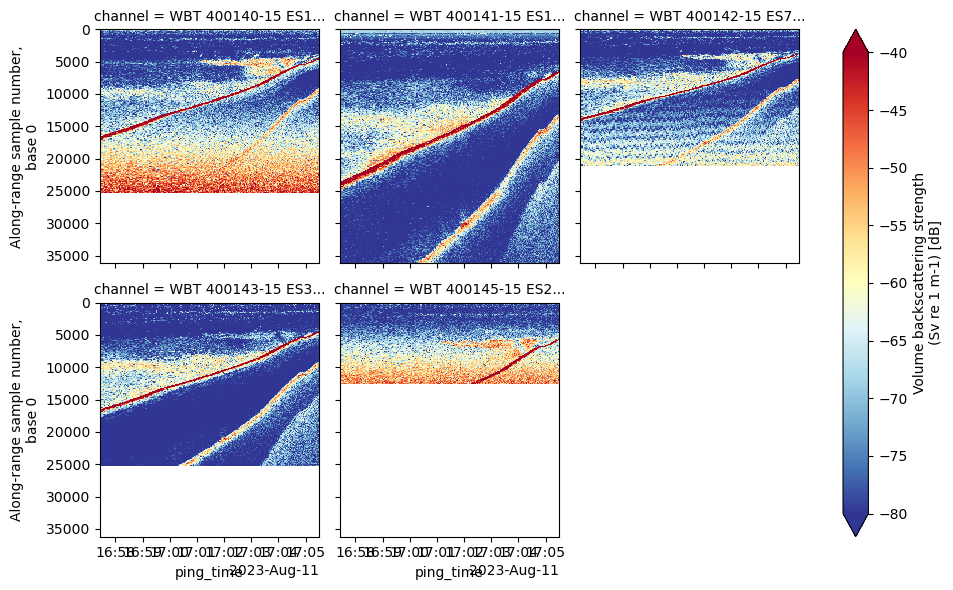

In [5]:
ds_Sv["Sv"].plot(
    x="ping_time", 
    row="channel", col_wrap=3,
    vmin=-80, vmax=-40,
    cmap="RdYlBu_r", yincrease=False
)

Adjust the colourbar range to highlight the seafloor.

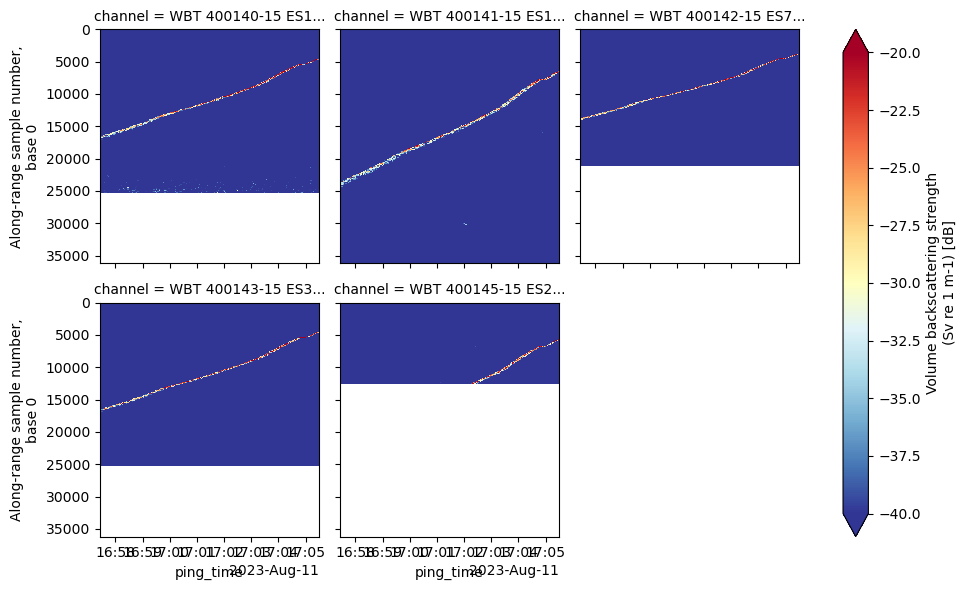

In [6]:
ds_Sv["Sv"].plot(
    x="ping_time", 
    row="channel", col_wrap=3,
    vmin=-40, vmax=-20,
    cmap="RdYlBu_r", yincrease=False
)

We show the 200 first samples, to observe the surface saturation zone. We need sto skip them with this very basic seafloor detection.

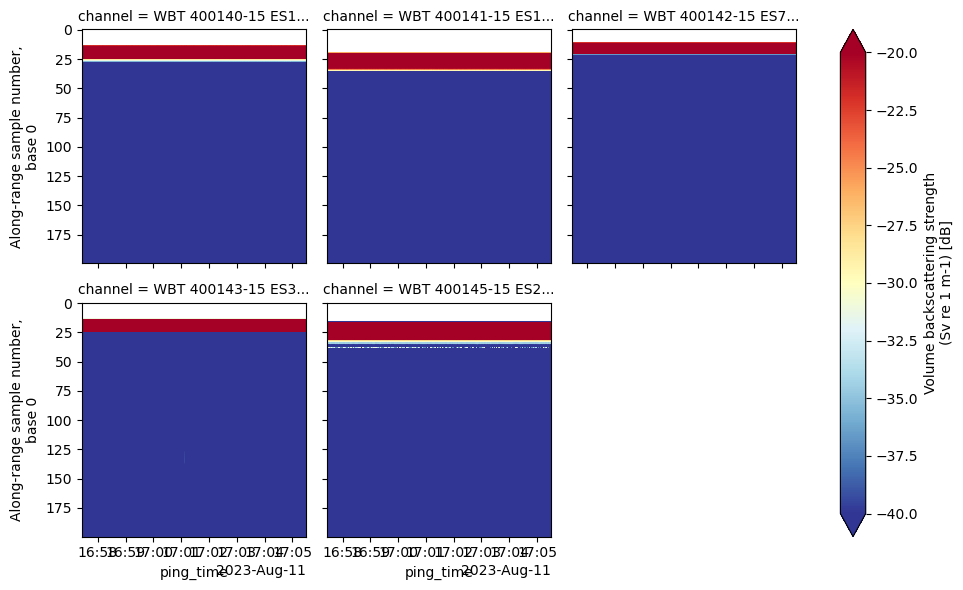

In [7]:
ds_Sv.isel(range_sample=slice(0, 200))["Sv"].plot(
    x="ping_time", 
    row="channel", 
    col_wrap=3,
    vmin=-40, vmax=-20,
    cmap="RdYlBu_r", 
    yincrease=False
)

# We detect seafloor with the mask subpackage

We use the basic bottom detection function from the seafloor_detection submodule within the echopype.mask package.
The computation is lazy: the bottom is only calculated when the values are accessed. We use here the 70 kHz channel to detect the seafloor.

In [9]:
from echopype.mask import detect_seafloor
import xarray as xr
# Call detect_seafloor dispatcher
bottom_depth = detect_seafloor(
    ds_Sv,
    method="basic",
    params={
        "var_name": "Sv",
        "channel": "WBT 400142-15 ES70-7C_ES",
        "threshold": (-40, -20),
        "offset_m": 0.3,
        "surface_skip": 200, # due to surface saturation with the basic method
    },
)

# Check output
assert isinstance(bottom_depth, xr.DataArray)
assert set(bottom_depth.dims) == {"ping_time"}
bottom_depth

<xarray.DataArray 'bottom_depth' (ping_time: 213)> Size: 2kB
array([496.74757004, 495.82407996, 493.19568514, 490.9935165 ,
       489.03997981, 487.15748082, 486.26950959, 485.23946297,
       483.67663362, 481.72309693, 479.62748484, 478.41984397,
       476.21767534, 473.83791246, 471.81333807, 469.96635792,
       468.68767936, 467.58659504, 466.13032223, 464.60301173,
       463.07570122, 461.83254151, 459.80796712, 458.31617546,
       455.47466754, 452.34900884, 451.10584912, 448.08674696,
       445.67146523, 444.00207933, 442.01302379, 439.59774206,
       437.71524306, 435.33548018, 434.23439587, 431.81911414,
       430.00765284, 429.29727586, 426.52680564, 423.96944852,
       421.23449715, 419.28096045, 416.33289599, 413.88209541,
       411.11162519, 409.12256965, 407.09799526, 404.50511929,
       401.87672446, 400.49148935, 398.8576223 , 396.83304791,
       395.16366201, 393.35220071, 391.00795668, 389.12545769,
       387.34951524, 386.49706286, 384.96975236, 382.69654602,
       381.34682976, 380.10367005, 378.36324645, 376.33867206,
       374.74032386, 373.1774945 , 371.96985364, 369.9807981 ,
       368.1693368 , 365.96716816, 364.93712154, 364.15570687,
       363.12566025, 361.74042514, 359.89344499, 358.50820988,
       357.19401247, 355.66670197, 353.74868412, 352.22137362,
...
       274.61268864, 273.33401008, 271.94877497, 270.17283252,
       268.61000316, 267.15373036, 265.48434446, 263.14010042,
       261.43519567, 260.40514905, 259.01991395, 257.06637725,
       254.40246358, 251.77406876, 250.24675825, 248.6128912 ,
       245.87793983, 243.99544084, 241.50912141, 239.48454702,
       237.21134068, 234.40535162, 232.20318298, 230.07205204,
       227.58573262, 226.20049751, 223.74969693, 221.61856599,
       219.06120887, 216.89455908, 214.72790929, 212.73885375,
       210.74979821, 209.18696885, 206.91376252, 204.32088655,
       202.4028687 , 199.84551158, 197.99853143, 196.43570208,
       194.58872193, 192.49310984, 190.4330166 , 188.692593  ,
       187.12976365, 184.82103847, 183.22269026, 181.55330436,
       179.31561688, 177.57519328, 175.65717544, 173.88123299,
       172.06977169, 170.79109313, 169.58345226, 169.26378262,
       169.12170723, 169.08618838, 168.4468491 , 167.91406636,
       167.20368938, 166.67090665, 165.53430348, 163.26109715,
       161.66274895, 160.81029657, 159.7447311 , 158.1463829 ,
       155.55350692, 152.78303671, 150.04808534, 148.52077483,
       147.06450202, 145.57271037, 144.96888993, 144.75577684,
       144.3650695 ])
Coordinates:
    channel    <U25 100B 'WBT 400142-15 ES70-7C_ES'
  * ping_time  (ping_time) datetime64[ns] 2kB 2023-08-11T16:57:27.277163 ... ...
Attributes:
    detector:       basic
    threshold_min:  -40.0
    threshold_max:  -20.0
    offset_m:       0.3
    surface_skip:   200
    channel:        WBT 400142-15 ES70-7C_ES

In [10]:
type(bottom_depth) # should be xarray.DataArray
bottom_depth.coords

Coordinates:
    channel    <U25 100B 'WBT 400142-15 ES70-7C_ES'
  * ping_time  (ping_time) datetime64[ns] 2kB 2023-08-11T16:57:27.277163 ... ...

We plot the seafloor. The bottom is computed because we access it.

In [11]:
bottom_depth

<xarray.DataArray 'bottom_depth' (ping_time: 213)> Size: 2kB
array([496.74757004, 495.82407996, 493.19568514, 490.9935165 ,
       489.03997981, 487.15748082, 486.26950959, 485.23946297,
       483.67663362, 481.72309693, 479.62748484, 478.41984397,
       476.21767534, 473.83791246, 471.81333807, 469.96635792,
       468.68767936, 467.58659504, 466.13032223, 464.60301173,
       463.07570122, 461.83254151, 459.80796712, 458.31617546,
       455.47466754, 452.34900884, 451.10584912, 448.08674696,
       445.67146523, 444.00207933, 442.01302379, 439.59774206,
       437.71524306, 435.33548018, 434.23439587, 431.81911414,
       430.00765284, 429.29727586, 426.52680564, 423.96944852,
       421.23449715, 419.28096045, 416.33289599, 413.88209541,
       411.11162519, 409.12256965, 407.09799526, 404.50511929,
       401.87672446, 400.49148935, 398.8576223 , 396.83304791,
       395.16366201, 393.35220071, 391.00795668, 389.12545769,
       387.34951524, 386.49706286, 384.96975236, 382.69654602,
       381.34682976, 380.10367005, 378.36324645, 376.33867206,
       374.74032386, 373.1774945 , 371.96985364, 369.9807981 ,
       368.1693368 , 365.96716816, 364.93712154, 364.15570687,
       363.12566025, 361.74042514, 359.89344499, 358.50820988,
       357.19401247, 355.66670197, 353.74868412, 352.22137362,
...
       274.61268864, 273.33401008, 271.94877497, 270.17283252,
       268.61000316, 267.15373036, 265.48434446, 263.14010042,
       261.43519567, 260.40514905, 259.01991395, 257.06637725,
       254.40246358, 251.77406876, 250.24675825, 248.6128912 ,
       245.87793983, 243.99544084, 241.50912141, 239.48454702,
       237.21134068, 234.40535162, 232.20318298, 230.07205204,
       227.58573262, 226.20049751, 223.74969693, 221.61856599,
       219.06120887, 216.89455908, 214.72790929, 212.73885375,
       210.74979821, 209.18696885, 206.91376252, 204.32088655,
       202.4028687 , 199.84551158, 197.99853143, 196.43570208,
       194.58872193, 192.49310984, 190.4330166 , 188.692593  ,
       187.12976365, 184.82103847, 183.22269026, 181.55330436,
       179.31561688, 177.57519328, 175.65717544, 173.88123299,
       172.06977169, 170.79109313, 169.58345226, 169.26378262,
       169.12170723, 169.08618838, 168.4468491 , 167.91406636,
       167.20368938, 166.67090665, 165.53430348, 163.26109715,
       161.66274895, 160.81029657, 159.7447311 , 158.1463829 ,
       155.55350692, 152.78303671, 150.04808534, 148.52077483,
       147.06450202, 145.57271037, 144.96888993, 144.75577684,
       144.3650695 ])
Coordinates:
    channel    <U25 100B 'WBT 400142-15 ES70-7C_ES'
  * ping_time  (ping_time) datetime64[ns] 2kB 2023-08-11T16:57:27.277163 ... ...
Attributes:
    detector:       basic
    threshold_min:  -40.0
    threshold_max:  -20.0
    offset_m:       0.3
    surface_skip:   200
    channel:        WBT 400142-15 ES70-7C_ES

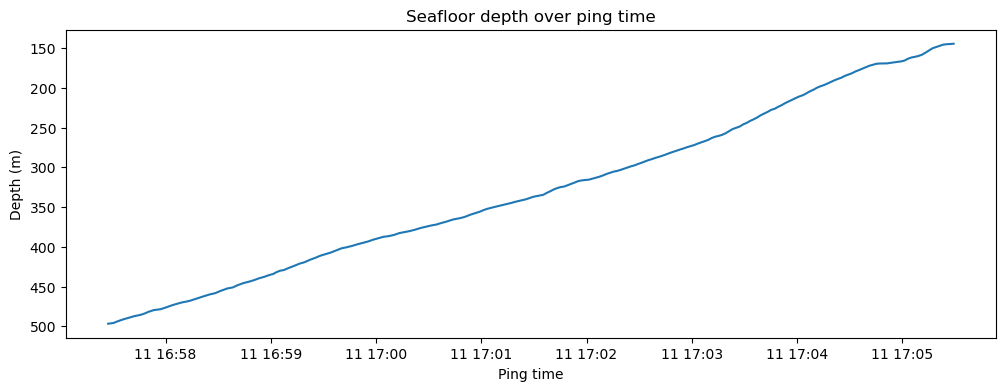

In [12]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(bottom_depth["ping_time"].values, bottom_depth.values, fillstyle='full', markersize=1)

ax.set_title("Seafloor depth over ping time")
ax.set_xlabel("Ping time")
ax.set_ylabel("Depth (m)")
ax.invert_yaxis()
plt.show()


We create a Dataset (here ds_single) where depth is a coordinate (not just a variable), allowing Sv to be plotted as an xarray object for a single channel.
This structure is also required to interface smoothly with the echoregions package.

In [13]:
import xarray as xr

selected_channel = "WBT 400141-15 ES18_ES"
frequency_dict = {
    "WBT 400140-15 ES120-7C_ES": 120000,
    "WBT 400141-15 ES18_ES": 18000,
    "WBT 400142-15 ES70-7C_ES": 70000,
    "WBT 400143-15 ES38B_ES": 38000,
    "WBT 400145-15 ES200-7C_ES": 200000,
}

# Extract Sv, time, and depth (first ping)
Sv_da = ds_Sv["Sv"].sel(channel=selected_channel)
depth = ds_Sv["depth"].sel(channel=selected_channel).isel(ping_time=0).sortby("range_sample")

# Build DataArray with (ping_time, depth) and add channel dim
Sv_plot = xr.DataArray(
    data=Sv_da.values,
    dims=["ping_time", "depth"],
    coords={"ping_time": Sv_da["ping_time"], "depth": depth.data},
    name="Sv"
).expand_dims(channel=[selected_channel])

# Wrap into Dataset and add frequency_nominal
ds_single = xr.Dataset({
    "Sv": Sv_plot,
    "frequency_nominal": xr.DataArray([frequency_dict[selected_channel]], dims=["channel"], coords={"channel": [selected_channel]})
})

In [14]:
ds_single

<xarray.Dataset> Size: 62MB
Dimensions:            (channel: 1, ping_time: 213, depth: 36198)
Coordinates:
  * channel            (channel) object 8B 'WBT 400141-15 ES18_ES'
  * ping_time          (ping_time) datetime64[ns] 2kB 2023-08-11T16:57:27.277...
  * depth              (depth) float64 290kB 9.8 9.821 9.841 ... 759.8 759.8
Data variables:
    Sv                 (channel, ping_time, depth) float64 62MB nan ... -74.28
    frequency_nominal  (channel) int32 4B 18000

We can now use echoregions to generate a mask from the detected seafloor line. (Note: the mask is applied here only to a single frequency.)

In [15]:
import pandas as pd

# Create minimal DataFrame with required columns
df = pd.DataFrame({
    "time": bottom_depth["ping_time"].values,
    "depth": bottom_depth.values,
})

# Save to CSV (required at the moment)
# For now commented, because already exist in ./example_data
# df.to_csv("./seafloor_detection/bottom_depth_minimal.csv", index=False)


In [16]:
import echoregions as er

lines = er.read_lines_csv("./example_data/seafloor_detection/bottom_depth_minimal.csv")

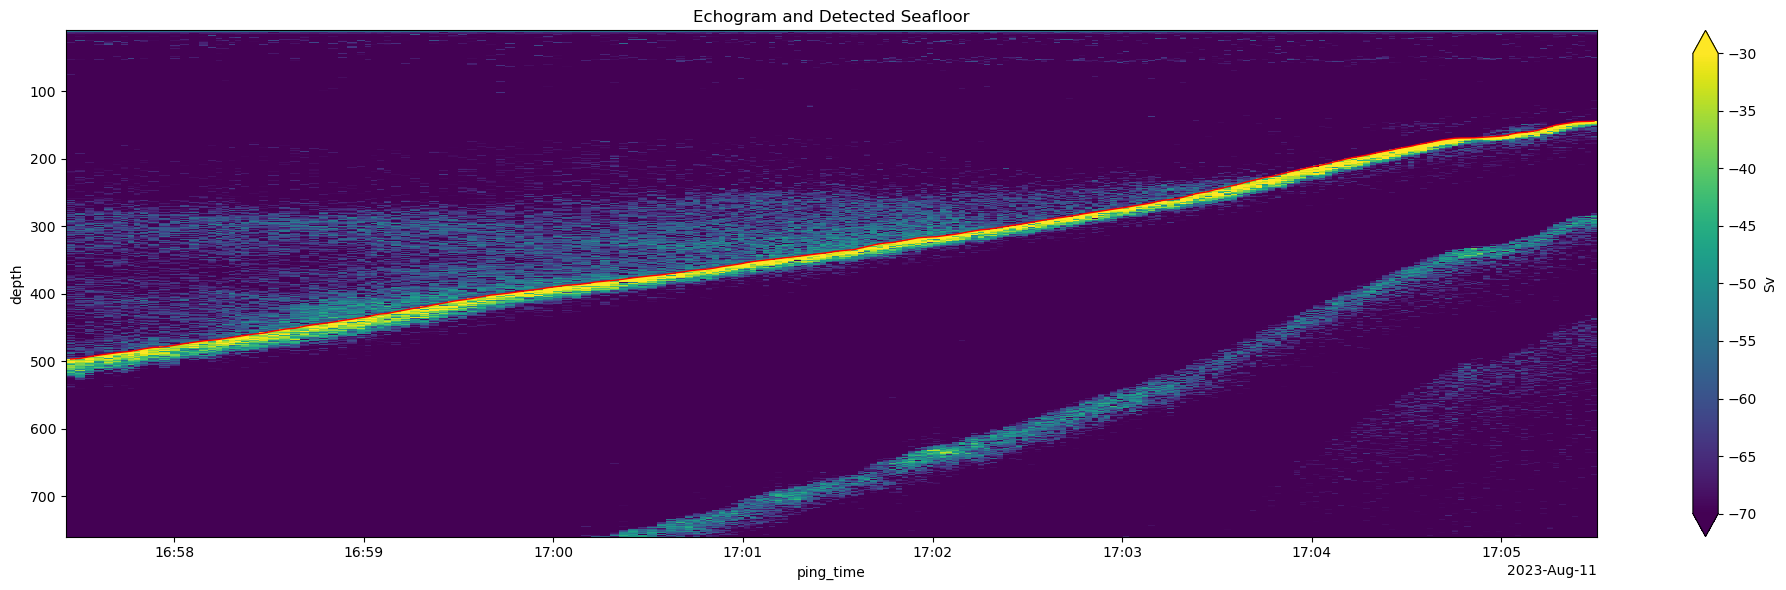

In [17]:
plt.figure(figsize=(20, 6))

# Plot Sv echogram for one channel
ds_single["Sv"].isel(channel=0).T.plot.pcolormesh(
    y="depth", yincrease=False, vmin=-70, vmax=-30
)

# Plot seafloor line from echoregions Lines object
plt.plot(
    lines.data['time'], lines.data['depth'], 
    color='red', label='Bottom', linewidth=1
)

plt.title("Echogram and Detected Seafloor")
plt.tight_layout()
plt.show()


In [18]:
# Use the built in mask function
bottom_mask_da, bottom_points = lines.bottom_mask(
    ds_single.Sv,
    operation="above_below",
    method="slinear",
    limit_area=None,
    limit_direction="both"
)

bottom_mask_da

<xarray.DataArray (depth: 36198, ping_time: 213)> Size: 31MB
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]])
Coordinates:
  * depth      (depth) float64 290kB 9.8 9.821 9.841 9.862 ... 759.7 759.8 759.8
  * ping_time  (ping_time) datetime64[ns] 2kB 2023-08-11T16:57:27.277163 ... ...

In [19]:
import numpy as np
print("Unique Values in Bottom Mask:", np.unique(bottom_mask_da.data))

Unique Values in Bottom Mask: [0 1]


In [20]:
print("Bottom Mask Ping Time Dimension Length:", len(bottom_mask_da["ping_time"]))
print("Bottom Mask Depth Dimension Length:", len(bottom_mask_da["depth"]))
print("Echogram Ping Time Dimension Length:", len(ds_single.Sv["ping_time"]))
print("Echogram Depth Dimension Length:", len(ds_single.Sv["depth"]))

Bottom Mask Ping Time Dimension Length: 213
Bottom Mask Depth Dimension Length: 36198
Echogram Ping Time Dimension Length: 213
Echogram Depth Dimension Length: 36198


We plot the mask.

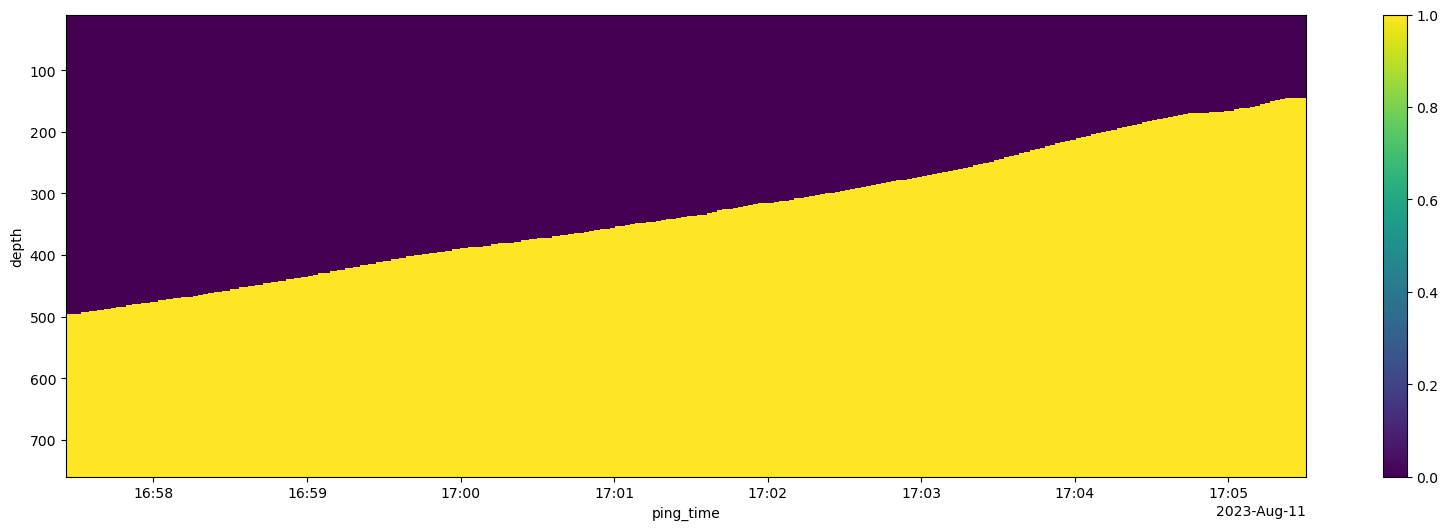

In [21]:
plt.figure(figsize = (20, 6))
bottom_mask_da.plot(y="depth", yincrease=False)

In [22]:
# Invert 1/0 or True/False mask to match echopype apply_mask expectations
inverted_mask = ~bottom_mask_da.astype(bool)

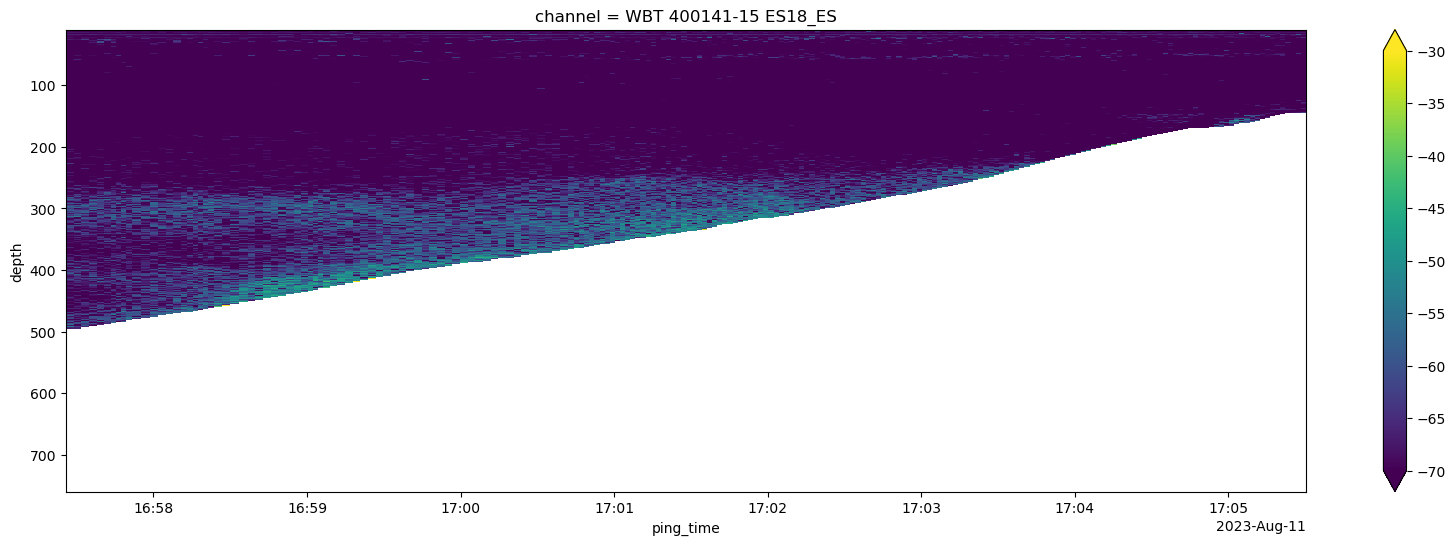

In [23]:
import echopype as ep

# Get only channel values where the mask is 1
mask_exists_Sv = xr.where(
    inverted_mask == 1,
    ds_single["Sv"].isel(channel=0),
    np.nan,
)

# Plot the masked Sv
plt.figure(figsize = (20, 6))
mask_exists_Sv.plot.pcolormesh(y="depth", yincrease=False, vmin=-70, vmax=-30)

We use apply_mask from the echopype.mask to the dataset

In [24]:
from echopype.mask import apply_mask
import numpy as np

print(ds_single["Sv"].dims)
print(ds_single["Sv"].shape)
print(inverted_mask.dims)
print(inverted_mask.shape)

# Transpose to match ('ping_time', 'depth')
bottom_mask_fixed = inverted_mask.transpose("ping_time", "depth")

ds_with_mask = apply_mask(ds_single, bottom_mask_fixed, var_name="Sv", fill_value=np.nan)

('channel', 'ping_time', 'depth')
(1, 213, 36198)
('depth', 'ping_time')
(36198, 213)


In [25]:
ds_with_mask

<xarray.Dataset> Size: 62MB
Dimensions:            (channel: 1, ping_time: 213, depth: 36198)
Coordinates:
  * channel            (channel) object 8B 'WBT 400141-15 ES18_ES'
  * ping_time          (ping_time) datetime64[ns] 2kB 2023-08-11T16:57:27.277...
  * depth              (depth) float64 290kB 9.8 9.821 9.841 ... 759.8 759.8
Data variables:
    Sv                 (channel, ping_time, depth) float64 62MB nan nan ... nan
    frequency_nominal  (channel) int32 4B 18000
Attributes:
    mask_software_name:     echopype
    mask_software_version:  0.10.2.dev14+g6577594.d20250803
    mask_time:              2025-08-03T22:26:29+00:00
    mask_function:          mask.apply_mask

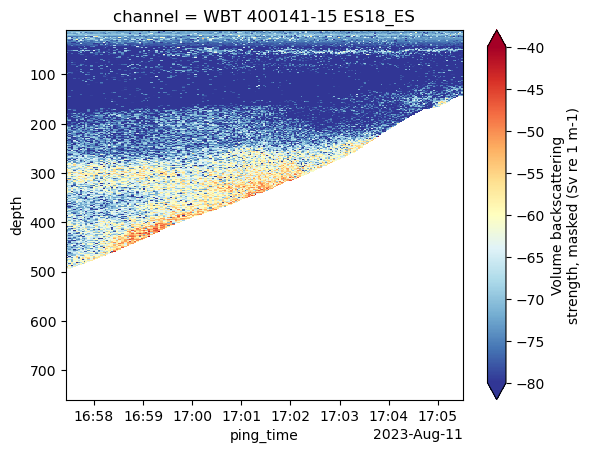

In [26]:
ds_with_mask["Sv"].plot(
    x="ping_time", 
    vmin=-80, vmax=-40,
    cmap="RdYlBu_r", yincrease=False
)

We compute and plot MVBS using the mask computed with the mask subpackage.

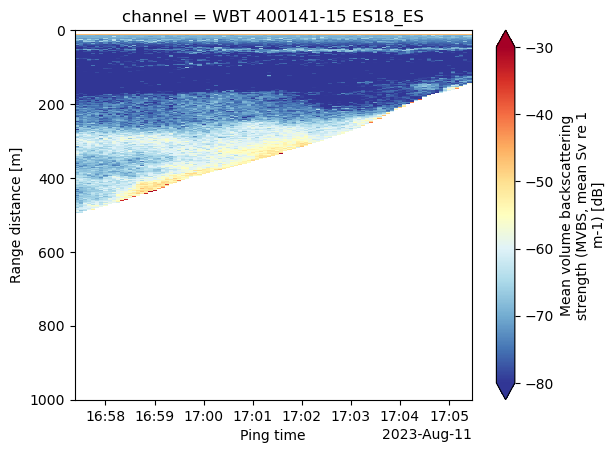

In [27]:
# Compute MVBS
ds_MVBS_mask = ep.commongrid.compute_MVBS(
    ds_with_mask,
    range_var="depth",
    range_bin="1m",
    ping_time_bin="5s",
    range_var_max="1000m",
)

ds_MVBS_mask["Sv"].plot(
    x="ping_time", cmap='RdYlBu_r', yincrease=False,
    vmin=-80, vmax=-30
)